# Similar Product Search

## Packages

In [ ]:
!pip install fastai -Uqq

In [37]:
from fastai.vision.all import *
from torch.optim import AdamW
from tqdm import tqdm

## Download dataset

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "lkarjun"
os.environ['KAGGLE_KEY'] = "96d0e367426087ce8a91876ea3de5244"

In [ ]:
!kaggle datasets download -d kritanjalijain/outfititems
!unzip outfititems.zip

In [ ]:
dataset_path = Path("/content/val/val")

## Here we go

### Dataloader

In [ ]:
def get_fnames(dataset_path, folders: list, n_files = 300):
  fnames = []
  full_fnames = []
  for folder in folders:
    for sub_folder in (dataset_path/folder).iterdir():
      files = get_image_files(dataset_path/sub_folder)
      full_fnames += files
      fnames += files[:n_files]
  return fnames, full_fnames

In [ ]:
fnames, full_fnames = get_fnames(dataset_path, ['bottomwear', 'one-piece', 'footwear', 'upperwear', 'accessories'])

In [ ]:
BATCH_SIZE = 120
RESIZE = 224

def get_dls(fnames):
  dls = ImageDataLoaders.from_path_func(
                dataset_path, 
                fnames, 
                parent_label,
                batch_tfms = Normalize.from_stats(*imagenet_stats), 
                item_tfms = Resize(RESIZE), 
                bs=BATCH_SIZE
              )
  return dls

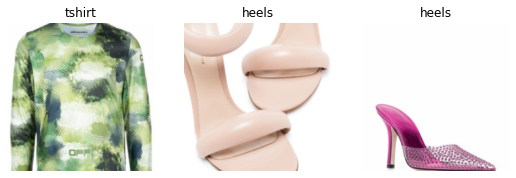

In [ ]:
dls = get_dls(fnames)

dls.show_batch(max_n = 3)

In [ ]:
dls.vocab

['bag', 'dress', 'flats', 'hat', 'heels', 'jacket', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 'sneakers', 'tshirt']

In [ ]:
x, y = dls.one_batch()
x.shape, y.shape, dls.c

(torch.Size([120, 3, 224, 224]), torch.Size([120]), 13)

### Model

In [ ]:
body = create_body(resnet50, cut=-2)

In [ ]:
head = create_head(nf = num_features_model(body), 
                   lin_ftrs=[2048, 512, 256, 128],
                   n_out = dls.c, 
                   concat_pool=False, 
                   pool=True)

In [ ]:
class RImgModel(Module):
    def __init__(self, body,head):
        self.body = body
        self.head = head
    
    def forward(self, x):
        x = self.body(x)
        return self.head(x)

In [ ]:
model = RImgModel(body, head).cuda()

In [ ]:
def model_splitter(model):
    return L(model.body, model.head).map(params)

In [ ]:
learn = Learner(dls, model,
                splitter = model_splitter, 
                metrics=[accuracy, error_rate])

In [ ]:
learn.summary()

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(5, 3e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.047050,2.151231,0.546309,0.453691,00:36
1,0.809378,0.828183,0.777181,0.222819,00:35
2,0.680692,1.178389,0.736913,0.263087,00:36


KeyboardInterrupt: ignored

In [36]:
# slice lr: lower lr for body and high for head

learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.189857,0.228551,0.927517,0.072483,00:47
1,0.174617,0.219690,0.928859,0.071141,00:44
2,0.154524,0.219813,0.924832,0.075168,00:45
3,0.151975,0.221682,0.928859,0.071141,00:45


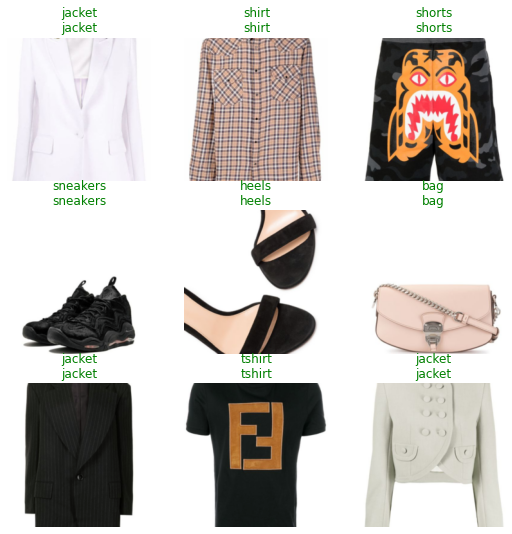

In [38]:
learn.show_results()

In [40]:
intrep = ClassificationInterpretation.from_learner(learn)

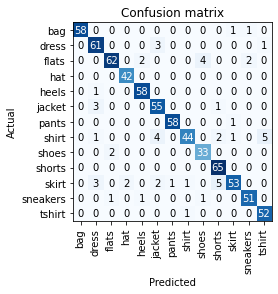

In [41]:
intrep.plot_confusion_matrix()

### Geting feature vector

In [42]:
learn.model.head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=2054, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(2054, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=2054, out_features=512, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.25, inplace=False)
  (12): Linear(in_features=512, out_features=256, bias=False)
  (13): ReLU(inplace=True)
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.25, inplace=False)
  (16): Linear(in_features=256, out_features=128, bias=False)
  (17): ReLU(inplace=True)
  (18): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine

In [43]:
def get_feature_vector(learn, X = None, dl = None, batch = False):
  with hook_output(learn.model.head[16]) as h:
    if batch:
      y = learn.get_preds(dl=dl)
    else:
      y = learn.predict(X)
  return h.stored

In [44]:
def process_batch(fnames, learn):
  features = []
  dl = learn.dls.test_dl(fnames)
  for i in tqdm(range(0, len(fnames), BATCH_SIZE)):
      names = fnames[i:i + BATCH_SIZE]
      dl = learn.dls.test_dl(names)
      features += get_feature_vector(dl = dl, batch = True, learn = learn)

  features = torch.stack(features, dim = 0).cpu().numpy()
  return features

In [45]:
features = process_batch(fnames, learn)

  0%|          | 0/32 [00:00<?, ?it/s]

  3%|▎         | 1/32 [00:02<01:05,  2.13s/it]

  6%|▋         | 2/32 [00:04<01:01,  2.03s/it]

  9%|▉         | 3/32 [00:05<00:56,  1.95s/it]

 12%|█▎        | 4/32 [00:07<00:52,  1.86s/it]

 16%|█▌        | 5/32 [00:09<00:49,  1.82s/it]

 19%|█▉        | 6/32 [00:11<00:49,  1.90s/it]

 22%|██▏       | 7/32 [00:13<00:48,  1.93s/it]

 25%|██▌       | 8/32 [00:15<00:46,  1.93s/it]

 28%|██▊       | 9/32 [00:17<00:44,  1.92s/it]

 31%|███▏      | 10/32 [00:19<00:41,  1.90s/it]

 34%|███▍      | 11/32 [00:20<00:38,  1.84s/it]

 38%|███▊      | 12/32 [00:22<00:36,  1.82s/it]

 41%|████      | 13/32 [00:24<00:35,  1.85s/it]

 44%|████▍     | 14/32 [00:26<00:33,  1.87s/it]

 47%|████▋     | 15/32 [00:28<00:30,  1.79s/it]

 50%|█████     | 16/32 [00:29<00:27,  1.72s/it]

 53%|█████▎    | 17/32 [00:31<00:25,  1.69s/it]

 56%|█████▋    | 18/32 [00:32<00:23,  1.70s/it]

 59%|█████▉    | 19/32 [00:34<00:22,  1.70s/it]

 62%|██████▎   | 20/32 [00:36<00:21,  1.80s/it]

 66%|██████▌   | 21/32 [00:38<00:21,  1.92s/it]

 69%|██████▉   | 22/32 [00:41<00:19,  2.00s/it]

 72%|███████▏  | 23/32 [00:43<00:19,  2.14s/it]

 75%|███████▌  | 24/32 [00:45<00:16,  2.06s/it]

 78%|███████▊  | 25/32 [00:47<00:14,  2.05s/it]

 81%|████████▏ | 26/32 [00:49<00:12,  2.06s/it]

 84%|████████▍ | 27/32 [00:51<00:10,  2.02s/it]

 88%|████████▊ | 28/32 [00:53<00:07,  1.95s/it]

 91%|█████████ | 29/32 [00:55<00:05,  1.90s/it]

 94%|█████████▍| 30/32 [00:56<00:03,  1.91s/it]

 97%|█████████▋| 31/32 [00:58<00:01,  1.92s/it]

100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


In [ ]:
features.shape

(600, 128)

### Similar Images

In [46]:
from sklearn.neighbors import NearestNeighbors

def get_neighbor(features):
  neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute',metric='cosine')
  return neighbors.fit(features)

In [47]:
neighbors = get_neighbor(features)

In [50]:
pickle.dump(neighbors, open('neighbor.pkl', 'wb'))

In [48]:
def plot_similar_images(test_idx, features, fnames):
  distances, indices = neighbors.kneighbors([features[test_idx]])
  plt.imshow(Image.open(fnames[test_idx]))
  plt.title("Image")

  fig, axs = plt.subplots(2,5, figsize=(15, 10))

  for ax, idx, dis in zip(axs.flatten(), indices.flatten(), distances.flatten()):
    img = Image.open(fnames[idx])
    ax.imshow(img)
    ax.set_title(dis)

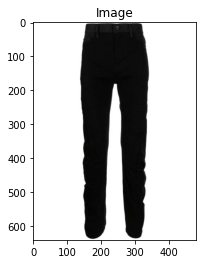

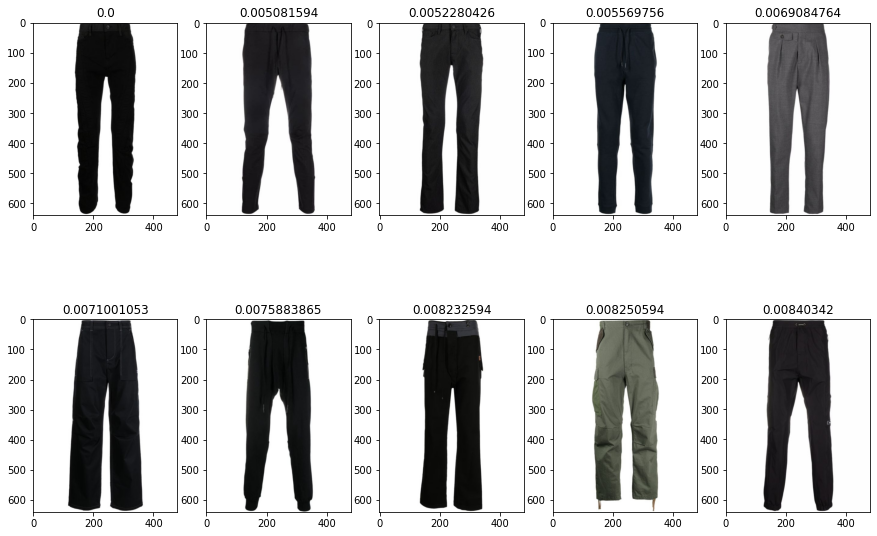

In [51]:
plot_similar_images(344, features, fnames)